In [3]:
import re
from pathlib import Path
import werpy
import jiwer
import pandas as pd

def clean_transcript(text):
    """
    Clean a transcript by removing linguistic annotations, formatting, and non-verbal markers.
    
    Args:
        text (str): The input transcript text
        
    Returns:
        str: The cleaned transcript text
    """
    # Replace speaker identifiers
    text = text.replace("INV1: ", "").replace("INV2: ", "").replace("PAR: ", "").replace("INV: ", "")
    
    # Replace basic formatting
    text = text.replace("‡", "")
    
    # Remove annotations like [+ gram], [+ exc], etc.
    text = re.sub(r'\[\+\s*[^\]]*\]', '', text)
    
    # Remove timing markers like (..), (.), (...)
    text = re.sub(r'\(\.\.\.\)|\(\.\.\)|\(\.\)', ' ', text)
    text = re.sub(r'\(\.+\)', '', text)  # More general pattern for (.), (..), (...)
    
    # Remove phonetic transcriptions like [: word]
    text = re.sub(r'\[:\s*[^\]]*\]', '', text)
    
    # Remove error codes like [* p:w], [* m:=ed], etc.
    text = re.sub(r'\[\*\s*[^\]]*\]', '', text)
    
    # Remove repetition markers like [/], [//]
    text = re.sub(r'\[\/\/?\]', '', text)
    
    # Remove pointing notes like &+points:picture
    text = re.sub(r'&\+points:[^\s]*', '', text)
    
    # Remove speech markers like &-, &+, +<, +/, +...
    text = re.sub(r'&[\+\-][a-z]*|\+[<\/]\s*|\+\.\.\.', '', text)
    
    
    # Remove special markers for retracings
    text = re.sub(r'\[\*\s*s:r:gc:pro-ret\]', '', text)
    
    # Remove 0det markers
    text = re.sub(r'0det\s*', '', text)
    
    # Clean up special characters
    text = re.sub(r'@q', '', text)
    text = re.sub(r'@l', '', text)
    
    # Remove sections in angle brackets that are immediately followed by corrections
    text = re.sub(r'<[^>]*>\s*\[\/{1,2}\]', '', text)
    
    # Fix contractions that were separated like (a)n(d)
    text = re.sub(r'\(a\)n\(d\)', 'and', text)
    text = re.sub(r'out_o\(f\)', 'out of', text)
    
    # Fix other common linguistic annotations
    text = re.sub(r'„', ',', text)
    
    # Clean up turn-taking markers
    text = re.sub(r'\*+', '', text)
    
    text = text.lower()
    
    # Further clean-up from additional patterns
    text = text.replace("&-", "").replace("*", "").replace("<", "").replace(">", "")
    text = text.replace("[", "").replace("]", "").replace("/", "")
    text = text.replace("+", "").replace("...", "").replace("..", "").replace("()", "")
    text = text.replace("xxx", "").replace("(", "").replace(")", "").replace("_", " ")
    text = text.replace("mhm", "").replace("hm.", "").replace(" hm ", " ").replace(" uh"," ").replace(" huh"," ")
    text = text.replace("hmm", "").replace("mm", "").replace("www", " ")
    
    # Remove filler words
    text = re.sub(r'\b(um|uh)\b', '', text)
    
    # Remove gestures and non-verbal cues
    text = re.sub(r'&=[a-z]+(:[a-z]+)?', '', text)
    
    # Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert to lowercase and trim
    
    text = text.strip()
    
    return text

def process_transcript_file(file_path):
    """
    Process a transcript file, clean it, and return the cleaned text.
    
    Args:
        file_path (str): Path to the transcript file
        
    Returns:
        str: The cleaned transcript text
    """
    try:
        with open(file_path, "r", encoding="utf-8") as gt_text:
            text = gt_text.read()
            return clean_transcript(text)
    except Exception as e:
        return f"Error processing {file_path}: {str(e)}"
    
def read_text(GT_path, check_path):
    check_path = Path(check_path)
    GT_path = Path(GT_path)
    if not check_path.exists() or not GT_path.exists():
        print("Error: File not found.")
    else:    
        with open(GT_path, "r", encoding="utf-8") as file:
            GT = file.read().strip()
        with open(check_path, "r", encoding="utf-8") as file:
            check = file.read().strip()
    return GT, check


def process_wer_data(num_list, models_list, result_type):
    """
    Processes WER data and updates the specified result type.

    Args:
        num_list (list): List of numerical identifiers.
        models_list (list): List of models to evaluate.
        result_type (str): One of ['wer', 'insertions', 'deletions', 'substitutions'].
    
    Returns:
        dict: A dictionary with WER results based on the selected result type.
    """
    # Initialize result storage
    results = {num: [] for num in num_list}

    for num in num_list:
        GT_path = f"Check/{num}/GT_{num}.txt"
        for model in models_list:
            check_path = f"Check/{num}/{model}_{num}.txt"
            
            ref = process_transcript_file(GT_path)
            hyp = process_transcript_file(check_path)
            # Read ground truth and hypothesis
            #ref, hyp = read_text(GT_path, check_path)
            reference = werpy.normalize(ref)
            hypothesis = werpy.normalize(hyp)

            # Compute WER results
            result = jiwer.process_words(reference, hypothesis)

            # Append based on the result type
            if result_type == 'wer':
                results[num].append(result.wer)
            elif result_type == 'insertions':
                results[num].append(result.insertions)
            elif result_type == 'deletions':
                results[num].append(result.deletions)
            elif result_type == 'substitutions':
                results[num].append(result.substitutions)
            else:
                raise ValueError("Invalid result type. Choose from 'wer', 'insertions', 'deletions', 'substitutions'.")

    return results

def dict_to_dataframe(result_dict, models_list):
    """
    Converts a dictionary of WER-related results into a Pandas DataFrame.
    
    Args:
        result_dict (dict): Dictionary where keys are numbers and values are lists of results.
        models_list (list): List of models used in evaluation.
    
    Returns:
        pd.DataFrame: DataFrame with numbers as index and models as columns.
    """
    # Create a structured dictionary to hold the results
    structured_data = {num: {model: None for model in models_list} for num in result_dict.keys()}

    # Populate structured data with actual values
    for num, values in result_dict.items():
        for idx, model in enumerate(models_list):
            if idx < len(values):  # Ensure values exist for the given index
                structured_data[num][model] = values[idx]
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(structured_data, orient='index')
    df.index.name = "Number"
    return df



# WER

In [4]:
num_list = ["1554","1713","1731","1738","1833","1944"]
models_list = ["largeV3","largeV3C","base","baseC"]
wer_results = {num: [] for num in num_list}
insert_results = {num: [] for num in num_list}
delete_results = {num: [] for num in num_list}
substitution_results = {num: [] for num in num_list}

wer_results = process_wer_data(num_list, models_list, 'wer')
insert_results = process_wer_data(num_list, models_list, 'insertions')
delete_results = process_wer_data(num_list, models_list, 'deletions')
substitution_results = process_wer_data(num_list, models_list, 'substitutions')

wer_df = dict_to_dataframe(wer_results, models_list)
insert_df = dict_to_dataframe(insert_results, models_list)
delete_df = dict_to_dataframe(delete_results, models_list)
substitution_df = dict_to_dataframe(substitution_results, models_list)
wer_df

,largeV3,largeV3C,base,baseC
Number,,,,
1554,0.102595,0.083585,0.150875,0.370851
1713,0.103530,0.086558,0.124915,0.124915
1731,0.136406,0.210810,0.325222,0.325222
1738,0.161010,0.130229,0.170087,0.170087
1833,0.116974,0.092348,0.173556,0.173556
1944,0.105156,0.105156,0.199898,0.199898


<Figure size 640x480 with 0 Axes>

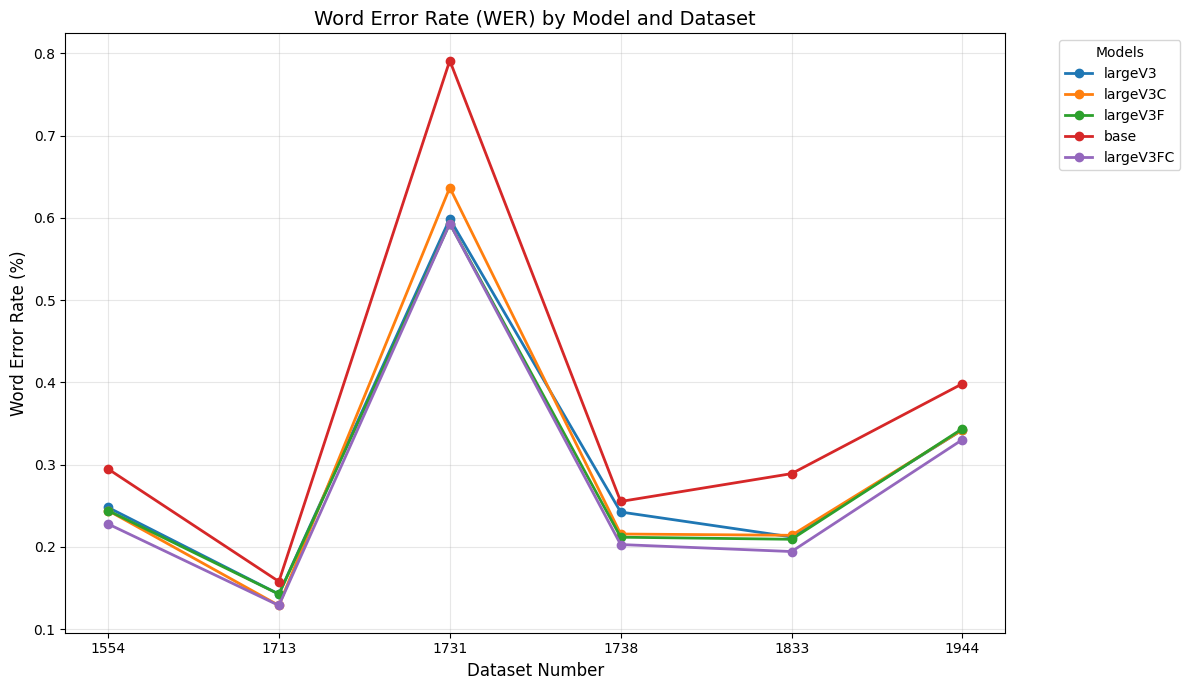

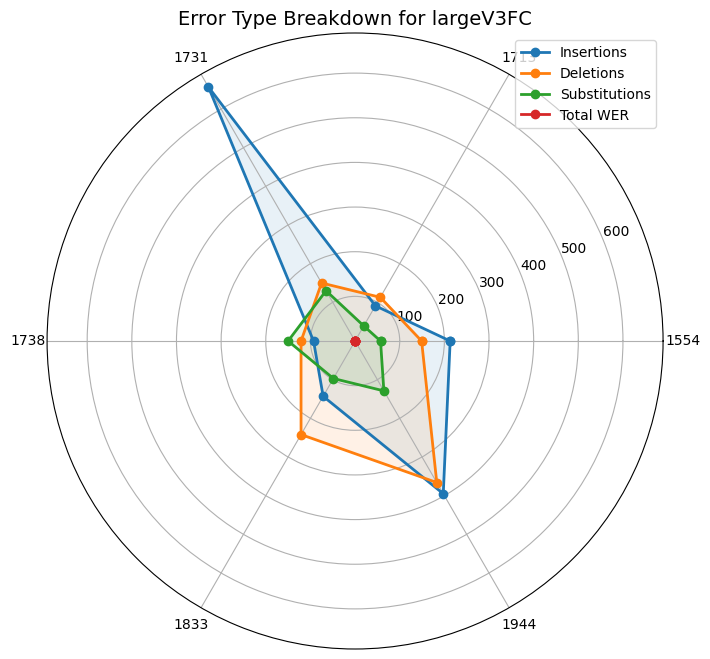

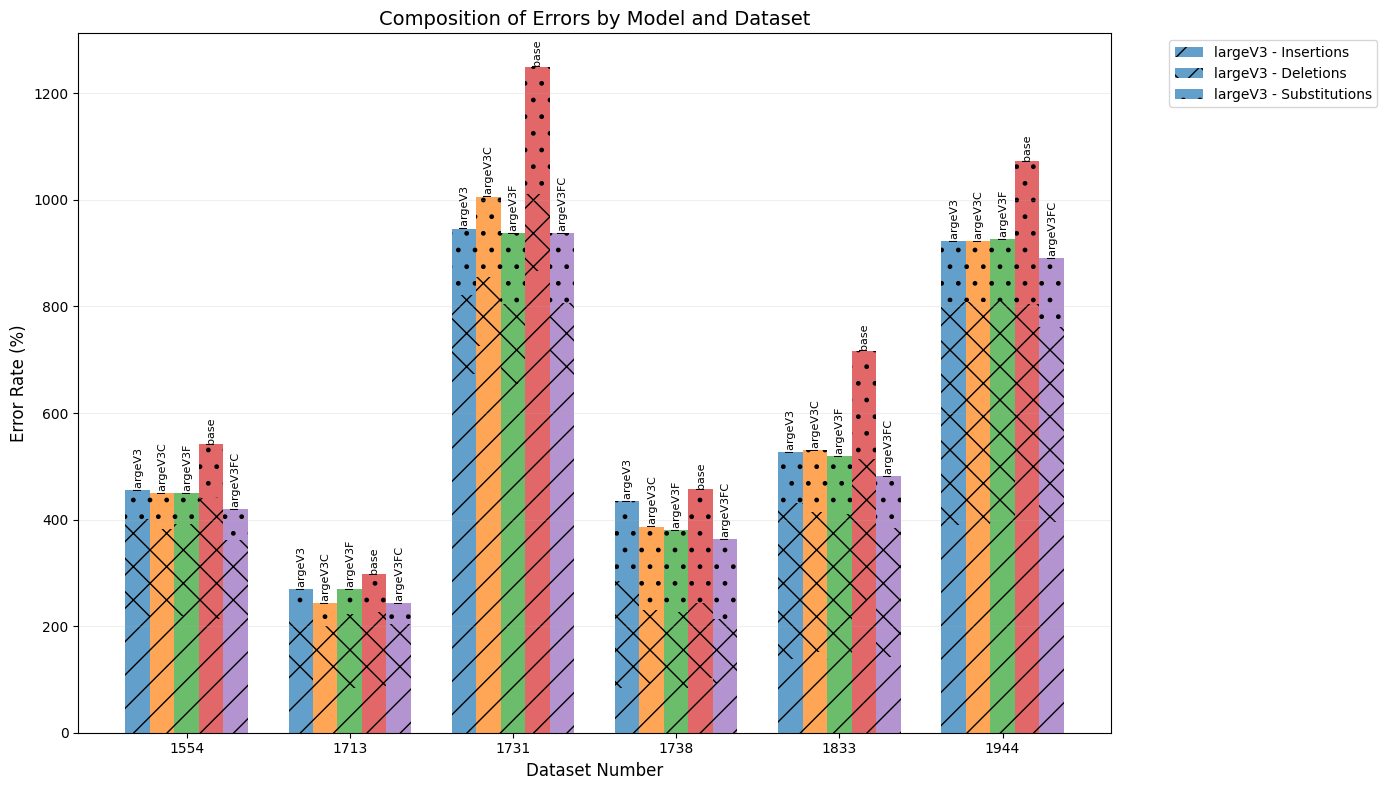

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Assuming wer_df, insert_df, delete_df, and substitution_df are already defined as shown in your code

def plot_wer_line_chart(wer_df, title="Word Error Rate (WER) by Model and Dataset"):
    """
    Creates a line chart showing WER values across different models and datasets.
    """
    plt.figure(figsize=(12, 7))
    
    # Get dataset numbers for x-axis (removing the error rate in parentheses)
    dataset_numbers = [num.split()[0] for num in wer_df.index]
    
    # Plot line for each model
    for model in wer_df.columns:
        plt.plot(dataset_numbers, wer_df[model], marker='o', linewidth=2, label=model)
    
    plt.xlabel('Dataset Number', fontsize=12)
    plt.ylabel('Word Error Rate (%)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # # Add value annotations
    # for i, model in enumerate(wer_df.columns):
    #     for j, dataset in enumerate(dataset_numbers):
    #         plt.annotate(f"{wer_df[model].iloc[j]:.2f}%",
    #                     (dataset, wer_df[model].iloc[j]),
    #                     textcoords="offset points",
    #                     xytext=(0, 10),
    #                     ha='center')
    
    return plt

def plot_error_types_radar(model_name, insert_df, delete_df, substitution_df, wer_df):
    """
    Creates a radar chart showing different error types (insertions, deletions, substitutions)
    for a specific model across all datasets.
    """
    # Extract data for the specified model
    insertions = insert_df[model_name].values
    deletions = delete_df[model_name].values
    substitutions = substitution_df[model_name].values
    wer = wer_df[model_name].values
    
    # Get dataset labels
    datasets = [num.split()[0] for num in wer_df.index]
    
    # Set up the radar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, polar=True)
    
    # Number of datasets
    N = len(datasets)
    
    # Angle for each dataset on the radar chart
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Add data for each error type
    ax.plot(angles, list(insertions) + [insertions[0]], 'o-', linewidth=2, label='Insertions')
    ax.plot(angles, list(deletions) + [deletions[0]], 'o-', linewidth=2, label='Deletions')
    ax.plot(angles, list(substitutions) + [substitutions[0]], 'o-', linewidth=2, label='Substitutions')
    ax.plot(angles, list(wer) + [wer[0]], 'o-', linewidth=2, label='Total WER')
    
    # Fill area for each error type
    ax.fill(angles, list(insertions) + [insertions[0]], alpha=0.1)
    ax.fill(angles, list(deletions) + [deletions[0]], alpha=0.1)
    ax.fill(angles, list(substitutions) + [substitutions[0]], alpha=0.1)
    
    # Set dataset labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(datasets)
    
    # Add title and legend
    plt.title(f'Error Type Breakdown for {model_name}', size=14)
    plt.legend(loc='upper right')
    
    return plt

def plot_stacked_bar_chart(wer_df, insert_df, delete_df, substitution_df):
    """
    Creates a stacked bar chart showing the composition of errors for each model
    across all datasets.
    """
    plt.figure(figsize=(14, 8))
    
    # Get dataset numbers for x-axis
    datasets = [num.split()[0] for num in wer_df.index]
    
    # Set bar width and positions
    bar_width = 0.15
    r = np.arange(len(datasets))
    
    # Plot bars for each model
    for i, model in enumerate(wer_df.columns):
        # Calculate position for this model's group of bars
        position = r + (i - len(wer_df.columns)/2 + 0.5) * bar_width
        
        # Get data for this model
        insertions = insert_df[model].values
        deletions = delete_df[model].values
        substitutions = substitution_df[model].values
        
        # Create stacked bars
        plt.bar(position, insertions, bar_width, label=f'{model} - Insertions' if i == 0 else '', 
                color=f'C{i}', alpha=0.7, hatch='/')
        plt.bar(position, deletions, bar_width, bottom=insertions, 
                label=f'{model} - Deletions' if i == 0 else '', color=f'C{i}', alpha=0.7, hatch='x')
        plt.bar(position, substitutions, bar_width, bottom=insertions+deletions, 
                label=f'{model} - Substitutions' if i == 0 else '', color=f'C{i}', alpha=0.7, hatch='.')
        
        # Add model name at the top of each stacked bar
        for j, dataset in enumerate(datasets):
            total = insertions[j] + deletions[j] + substitutions[j]
            plt.text(position[j], total + 0.3, model, 
                     ha='center', va='bottom', rotation=90, fontsize=8)
    
    # Add labels and customize plot
    plt.xlabel('Dataset Number', fontsize=12)
    plt.ylabel('Error Rate (%)', fontsize=12)
    plt.title('Composition of Errors by Model and Dataset', fontsize=14)
    plt.xticks(r, datasets)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.2, axis='y')
    plt.tight_layout()
    
    return plt

# Plot the visualizations
plt.figure(1)
plot_wer_line_chart(wer_df)
plt.savefig('wer_line_chart.png')

plt.figure(2)
# Choose a model for the radar chart (e.g., the first one)
plot_error_types_radar(models_list[4], insert_df, delete_df, substitution_df, wer_df)
plt.savefig('error_types_radar.png')

plt.figure(3)
plot_stacked_bar_chart(wer_df, insert_df, delete_df, substitution_df)
plt.savefig('stacked_bar_chart.png')

plt.show()

Showing results below matters because it shows that cleaning wasn't chaotic.

In [5]:
num="1833"
model="largeV3FC"

ref = process_transcript_file(f"Aphasia/output/{num}/GT_{num}.txt")
#hyp.replace(" uh"," ").replace(" huh"," ")
# hyp = process_transcript_file( f"Aphasia/output/{num}/{model}_{num}.txt")
hyp = process_transcript_file( f"Aphasia/1738c.txt")
reference = werpy.normalize(ref) #ref
hypothesis = werpy.normalize(hyp)
result = jiwer.process_words(reference, hypothesis)
print(hypothesis)

alignments = result.alignments[0]

ref_words = reference.split()
hyp_words = hypothesis.split()

deletions = []
insertions = []
insertions_map = {}
substitutions = []
substitutions_map = {}
correct = []

ref_dict = {}
hyp_dict = {}

for alignment in alignments:
    if alignment.type == 'delete':
        deletions.extend(ref_words[alignment.ref_start_idx:alignment.ref_end_idx])
    elif alignment.type == 'insert':
        word = hyp_words[alignment.hyp_start_idx:alignment.hyp_end_idx]
        insertions.extend(word)
    elif alignment.type == 'substitute':
        words = (ref_words[alignment.ref_start_idx], hyp_words[alignment.hyp_start_idx])
        substitutions_map[words] = (alignment.ref_start_idx, alignment.hyp_start_idx)
        substitutions.append(words)
    elif alignment.type == 'equal':
        correct.extend(ref_words[alignment.ref_start_idx:alignment.ref_end_idx])

print(reference)
print(hypothesis)

print("Deletions:", len(deletions))
print("Insertions:", len(insertions))
print("Substitutions:", len(substitutions))
print("Correct words:", len(correct))


print("Deletions:", deletions)
print("Insertions:", insertions)
print("Substitutions:", substitutions)
print("Correct words:", correct)
#checked till: ('very', 'real')

so first im just gonna be asking you to do some talking okay so how do you think your speech is these days days very erratic im close to ten years since the stroke and ive been more talking for the last seven and at times this time oftenth year i can wake up and feel funfine pronounce things very carefully other the times im off in the fall somewhere about back and forth more than others past years so anything else yeah sure so do you remember when you had your stroke yeah could you tell me about it as late in december i was alone in my small house behind my frontfriend offrom my doorsdaughter and i suddenly i suddenly wantwent to i would say at this point ill say blank but going back isas far beyond this i couldnt get a hold of myself and i was in the house was very cold its very messy and i sat there from somewhere between two and three days so wow yeah okay my eventually my daughter came in so itsthats a long time though yeah it was realvery long i couldnt move yeah yeah and so how 

# Assembly AI

In [26]:
assembly_results = []
for n in num_list:
    
    assembly_transcript = process_transcript_file(f"Dataset/Ground_Truth/commercial_{n}.txt")
    ref = process_transcript_file(f"Dataset/Ground_Truth/GT_{n}.txt")
    ref_normalized = werpy.normalize(ref) 
    assembly_normalized = werpy.normalize(assembly_transcript) 
    assembly_normalized = assembly_normalized.replace(" um ", " ").replace(" uh ", " ").replace("10", "ten").replace("11","eleven")

    result = jiwer.process_words(ref_normalized, assembly_normalized)
    assembly_results.append(result.wer)


wer_df['assemblyAI'] = assembly_results
wer_df

,largeV3,largeV3C,largeV3F,base,largeV3FC,assemblyAI
Number,,,,,,
1554,0.248238,0.247154,0.243902,0.294309,0.227642,0.205962
1713,0.143687,0.129424,0.143687,0.158479,0.129424,0.145800
1731,0.615819,0.647834,0.591965,0.789705,0.605775,0.644696
1738,0.242627,0.216472,0.211464,0.254869,0.202560,0.200334
1833,0.212560,0.214573,0.209742,0.288647,0.194042,0.188406
1944,0.342105,0.342105,0.344329,0.397702,0.329874,0.350259


# Fine-Tuned

In [62]:
ft_results = []
for n in num_list:
    
    ft_transcript = process_transcript_file(f"output/{n}/fine_tuned_{n}.txt")
    ref = process_transcript_file(f"Dataset/Ground_Truth/GT_{n}.txt")
    ref_normalized = werpy.normalize(ref) 
    print(ref_normalized)
    ft_normalized = werpy.normalize(ft_transcript) 
    print(ft_normalized)
    #assembly_normalized = assembly_normalized.replace(" um ", " ").replace(" uh ", " ").replace("10", "ten").replace("11","eleven").replace(" hmm ", " ").replace(" mm ", " ")

    result = jiwer.process_words(ref_normalized, ft_normalized)
    ft_results.append(result.wer)

    break
ft_results
# wer_df['assemblyAI'] = assembly_results
# wer_df

so im just gonna be asking you to do some talking okay so how do you think your speech is these days its good but will be better i can little i can read a little bit i have trouble with an and the and and all that do you remember when you had your stroke yeah could you tell me about it oh gosh well i got i got up to check the laundry and i got about there in the doorway of the kitchen and i dont remember i go to vanderbilt and thats all i can remember hm what about your first memories after the stroke hm i was scared yeah okay so what about your recovery what kinds of things have you done to try to get better since your stroke i exercise five times a a week and i have speech spring christmas break starting up next tuesday wednesday the following week and i dont i dont know thats it i dont know doctors appointments and all that jazz so outside of exercising are there any other changes in your day to day life oh i i i cant work and i watch my grandson and thats it i can drive now oh yay 

[0.30886351277868407]